# Summary of the Entire Process 

**Generative bioenergetics model that learns interpretable equations for mitochondrial ATP, NADH, and ROS control of genetic functions using neural ODEs and symbolic regression.**

This project builds a virtual biological cell that simulates **how energy flows through molecular systems like ATP and NADH.** A hybrid AI model is trained to reproduce these energy dynamics. Then, symbolic regression translates what the neural network learned back into readable equations that scientists can understand. Finally, a PDF report combines all results, plots, parameters, and equations into a clean scientific summary. In short, you’ve made a self-learning, self-explaining biological simulator, it learns from data and then tells you the “rules” it discovered.

Epoch 0 Loss 0.08964
Epoch 200 Loss 0.00305
Epoch 400 Loss 0.00274
Epoch 600 Loss 0.00265
Epoch 800 Loss 0.00260
Epoch 1000 Loss 0.00257
Epoch 1200 Loss 0.00255
Epoch 1400 Loss 0.00254
Epoch 1600 Loss 0.00254
Epoch 1800 Loss 0.00253

Parameter summary
mechanistic.k_ros: 0.5151
mechanistic.k_nadh: 0.1134
mechanistic.alpha: 1.1971
correction.net.0.weight: tensor, shape (16, 3), mean 0.1028, std 0.3206
correction.net.0.bias: tensor, shape (16,), mean -0.0075, std 0.2762
correction.net.2.weight: tensor, shape (3, 16), mean 0.0054, std 0.1199
correction.net.2.bias: tensor, shape (3,), mean -0.0713, std 0.0971


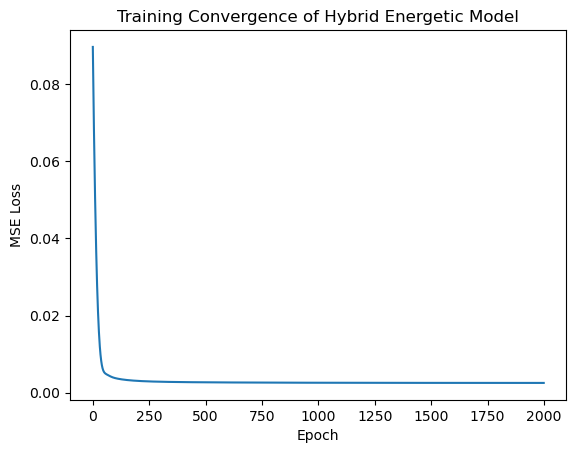

Correlation (Transcription predicted vs true): 0.992


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Simulate benchmark data
# Synthetic data: energy state variables and outputs
# ATP, NADH, ROS as inputs; transcription, repair, replication as outputs

def simulate_biochemical_data(n_samples=2000, noise=0.05, seed=42):
    np.random.seed(seed)
    ATP = np.random.uniform(0.1, 2.0, n_samples)
    NADH = np.random.uniform(0.1, 2.0, n_samples)
    ROS = np.random.uniform(0.01, 1.0, n_samples)

    # Mechanistic relationships (simplified biochemistry)
    transcription = (ATP / (1 + ROS)) * np.exp(-0.3 * ROS)
    repair = (NADH * ATP) / (1 + 0.5 * ROS)
    replication = (ATP**1.2) / (1 + ROS + 0.1 * NADH)

    # Add Gaussian noise
    transcription += np.random.normal(0, noise, n_samples)
    repair += np.random.normal(0, noise, n_samples)
    replication += np.random.normal(0, noise, n_samples)

    X = np.stack([ATP, NADH, ROS], axis=1)
    y = np.stack([transcription, repair, replication], axis=1)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 2. Mechanistic Layer
class MechanisticLayer(nn.Module):
    """
    Encodes biochemical priors:
    transcription ∝ ATP/(1 + ROS)
    repair ∝ (ATP * NADH)/(1 + k_ROS)
    replication ∝ ATP^(a)/(1 + ROS + k_NADH)
    """

    def __init__(self):
        super(MechanisticLayer, self).__init__()
        # Learnable biophysical constants
        self.k_ros = nn.Parameter(torch.tensor(0.5))
        self.k_nadh = nn.Parameter(torch.tensor(0.1))
        self.alpha = nn.Parameter(torch.tensor(1.2))

    def forward(self, X):
        ATP, NADH, ROS = X[:, 0], X[:, 1], X[:, 2]
        transcription = (ATP / (1 + ROS)) * torch.exp(-0.3 * ROS)
        repair = (ATP * NADH) / (1 + self.k_ros * ROS)
        replication = (ATP ** self.alpha) / (1 + ROS + self.k_nadh * NADH)
        return torch.stack([transcription, repair, replication], dim=1)

# 3. Neural Correction Module
class CorrectionNet(nn.Module):
    """
    Captures unmodeled interactions and higher-order corrections.
    Small and interpretable residual network.
    """

    def __init__(self, input_dim=3, output_dim=3, hidden_dim=16):
        super(CorrectionNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, X):
        return self.net(X)

# 4. Full Hybrid Model
class HybridEnergeticModel(nn.Module):
    def __init__(self):
        super(HybridEnergeticModel, self).__init__()
        self.mechanistic = MechanisticLayer()
        self.correction = CorrectionNet()

    def forward(self, X):
        mech = self.mechanistic(X)
        corr = self.correction(X)
        return mech + corr  # hybrid prediction

# 5. Training Loop
def train_model(model, X, y, epochs=2000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if epoch % 200 == 0:
            print(f"Epoch {epoch} Loss {loss.item():.5f}")
    return losses

# 6. Run Simulation
if __name__ == "__main__":
    X, y = simulate_biochemical_data()

    model = HybridEnergeticModel()
    losses = train_model(model, X, y)

    print("\nParameter summary")
    for name, p in model.named_parameters():
        if p.numel() == 1:
            print(f"{name}: {p.item():.4f}")
        else:
            arr = p.detach().cpu().numpy()
            print(f"{name}: tensor, shape {arr.shape}, mean {arr.mean():.4f}, std {arr.std():.4f}")

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training Convergence of Hybrid Energetic Model")
    plt.show()

    # Evaluate correlations
    with torch.no_grad():
        y_pred = model(X)
        corr = np.corrcoef(y_pred[:, 0].numpy(), y[:, 0].numpy())[0, 1]
        print(f"Correlation (Transcription predicted vs true): {corr:.3f}")

In [7]:
!pip install torchdiffeq

Simulating synthetic energy dynamics...
Training the hybrid Neural ODE model...
Epoch 0, Loss = 2.976206
Epoch 200, Loss = 0.017526
Epoch 400, Loss = 0.009439
Epoch 600, Loss = 0.004523
Epoch 800, Loss = 0.002959
Epoch 1000, Loss = 0.002329


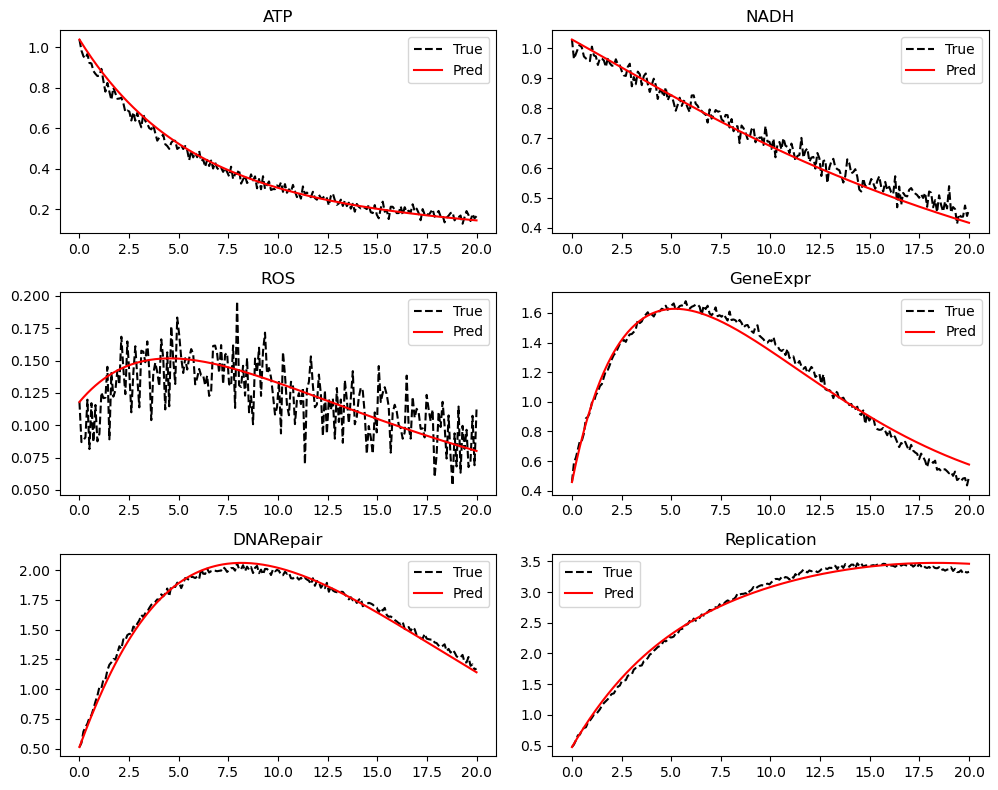

Parameter summary
k_trans: 0.7645
k_rep: 0.6676
k_repair: 0.6761
k_ros_decay: 0.1094
k_nadh_decay: 0.0557
corr.0.weight, tensor, shape (16, 5), mean 0.0394, std 0.2512
corr.0.bias, tensor, shape (16,), mean 0.0664, std 0.2714
corr.2.weight, tensor, shape (3, 16), mean -0.0002, std 0.1398
corr.2.bias, tensor, shape (3,), mean -0.0743, std 0.0436


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint

# 1. Define the dynamic biochemical system

class EnergeticODEFunc(nn.Module):
    """
    Defines d[gene_state]/dt as a function of ATP, NADH, ROS dynamics
    and mechanistic energy constraints.
    """

    def __init__(self):
        super(EnergeticODEFunc, self).__init__()
        # Learnable mechanistic constants (initial guesses)
        self.k_trans = nn.Parameter(torch.tensor(0.8))   # transcription efficiency
        self.k_rep = nn.Parameter(torch.tensor(0.6))     # replication rate constant
        self.k_repair = nn.Parameter(torch.tensor(0.7))  # repair rate constant
        self.k_ros_decay = nn.Parameter(torch.tensor(0.1))
        self.k_nadh_decay = nn.Parameter(torch.tensor(0.05))

        # Neural correction layer to capture unmodeled coupling
        self.corr = nn.Sequential(
            nn.Linear(5, 16),
            nn.Tanh(),
            nn.Linear(16, 3)
        )

    def forward(self, t, state):
        """
        state = [ATP, NADH, ROS, GeneExpression, DNARepair, Replication]
        """
        ATP, NADH, ROS, G, R, P = torch.split(state, 1, dim=-1)

        # Mechanistic kinetics
        dATP_dt = -0.2 * ATP + 0.05 * NADH - 0.01 * ROS
        dNADH_dt = -self.k_nadh_decay * NADH + 0.02 * ATP
        dROS_dt = 0.03 * ATP - self.k_ros_decay * ROS

        # Mechanistic energy-dependent outputs
        dG_dt = self.k_trans * (ATP / (1 + ROS)) - 0.05 * G
        dR_dt = self.k_repair * (ATP * NADH / (1 + ROS)) - 0.03 * R
        dP_dt = self.k_rep * (ATP ** 1.2 / (1 + ROS + 0.1 * NADH)) - 0.04 * P

        # Combine variables for neural correction
        inputs = torch.cat([ATP, NADH, ROS, G, R], dim=-1)
        d_corr = self.corr(inputs)

        # Add corrections to gene outputs only (not raw energetics)
        dG_dt += d_corr[:, [0]]
        dR_dt += d_corr[:, [1]]
        dP_dt += d_corr[:, [2]]

        return torch.cat([dATP_dt, dNADH_dt, dROS_dt, dG_dt, dR_dt, dP_dt], dim=-1)

# 2. Simulate synthetic time series data

def generate_synthetic_data(func, t_span, n_points=200, seed=42):
    torch.manual_seed(seed)
    # initial state: ATP, NADH, ROS, G, R, P
    y0 = torch.tensor([[1.0, 1.0, 0.1, 0.5, 0.5, 0.5]])
    t = torch.linspace(t_span[0], t_span[1], n_points)
    with torch.no_grad():
        y = odeint(func, y0, t, method='dopri5')
    # Add small Gaussian noise
    y += 0.02 * torch.randn_like(y)
    return t, y

# 3. Training procedure

def train_neural_ode(func, t, y_true, n_epochs=2000, lr=1e-3):
    optimizer = optim.Adam(func.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        y_pred = odeint(func, y_true[0], t, method='dopri5')
        loss = loss_fn(y_pred, y_true)
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.6f}")
    return func

# 4. Run benchmark

if __name__ == "__main__":
    print("Simulating synthetic energy dynamics...")

    # Initialize the system and generate synthetic benchmark data
    ground_truth_func = EnergeticODEFunc()
    t, y_true = generate_synthetic_data(ground_truth_func, [0, 20])

    # Create a new model to learn from the synthetic data
    model_func = EnergeticODEFunc()

    # Train the model on synthetic trajectories
    print("Training the hybrid Neural ODE model...")
    trained_func = train_neural_ode(model_func, t, y_true, n_epochs=1200)

    # Predict trajectories using the trained model
    with torch.no_grad():
        y_pred = odeint(trained_func, y_true[0], t)

    # Plot comparison
    labels = ["ATP", "NADH", "ROS", "GeneExpr", "DNARepair", "Replication"]
    plt.figure(figsize=(10, 8))
    for i in range(6):
        plt.subplot(3, 2, i + 1)
        plt.plot(t.numpy(), y_true[:, 0, i].numpy(), 'k--', label='True')
        plt.plot(t.numpy(), y_pred[:, 0, i].numpy(), 'r', label='Pred')
        plt.title(labels[i])
        plt.legend()
    plt.tight_layout()
    plt.show()

    print("Parameter summary")
    for name, p in trained_func.named_parameters():
        if p.numel() == 1:
            print(f"{name}: {p.item():.4f}")
        else:
            arr = p.detach().cpu().numpy()
            print(f"{name}, tensor, shape {arr.shape}, mean {arr.mean():.4f}, std {arr.std():.4f}")

In [61]:
import energetic_grammar_dynamics as egd
print(egd.__file__)
print([n for n in dir(egd) if not n.startswith("_")])
print(getattr(egd, "__all__", None))

/Users/petalc01/Generative Bioenergetics/energetic_grammar_dynamics.py
[]
None


In [64]:
import sys, importlib, os, pathlib
sys.modules.pop("energetic_grammar_dynamics", None)
import energetic_grammar_dynamics as egd
importlib.reload(egd)
print([n for n in dir(egd) if not n.startswith("_")])

['EnergeticODEFunc', 'generate_synthetic_data', 'nn', 'odeint', 'optim', 'torch', 'train_neural_ode']


In [66]:
from energetic_grammar_dynamics import EnergeticODEFunc, train_neural_ode, generate_synthetic_data
func = EnergeticODEFunc()
t, y = generate_synthetic_data(func)
print("ok", t.shape, y.shape)

ok torch.Size([200]) torch.Size([200, 1, 6])


In [68]:
from energetic_grammar_dynamics import EnergeticODEFunc, train_neural_ode, generate_synthetic_data

In [70]:
import energetic_grammar_dynamics as egd
print(egd.__file__)
from energetic_grammar_dynamics import EnergeticODEFunc, train_neural_ode, generate_synthetic_data
func = EnergeticODEFunc()
t, y = generate_synthetic_data(func)
print("ok, shapes", t.shape, y.shape)

/Users/petalc01/Generative Bioenergetics/energetic_grammar_dynamics.py
ok, shapes torch.Size([200]) torch.Size([200, 1, 6])


In [57]:
import sys
print(sys.path)

['/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/tmpqbzg00cf']


Generating dynamic synthetic trajectories...
Training hybrid ODE model...
Epoch 0, Loss = 0.000860
Epoch 200, Loss = 0.000411
Epoch 400, Loss = 0.000408
Epoch 600, Loss = 0.000408
Epoch 800, Loss = 0.000408


/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...


Running symbolic regression to extract governing equations...

Extracting symbolic rule for dGeneExpr_dt ...


/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.409e-02  0.000e+00  y = -0.027538
3           2.771e-02  2.322e-01  y = x₁ - 0.73091
4           2.389e-02  1.483e-01  y = 0.87534 - cos(x₀)
5           2.307e-02  3.510e-02  y = (x₀ * 0.64303) - 0.27397
6           2.229e-02  3.419e-02  y = (x₀ ^ x₀) - cos(x₁)
8           2.214e-02  3.551e-03  y = (x₀ ^ x₀) - cos(x₁ + -0.019501)
10          2.214e-02  7.182e-06  y = ((x₀ ^ x₀) - cos(0.015131 - x₁)) + -0.0028583
12          2.210e-02  7.901e-04  y = (x₀ ^ x₀) - (cos((x₁ + -0.19483) * 1.1722) / 1.0559)
13          2.196e-02  6.197e-03  y = 0.84495 - cos(0.098602 ^ cos(x₁ * (-1.5298 - (x₀ * x₂)...
                                      )))
17          2.190e-02  7.075e-04  y = 0.84495 - cos((x₂ * 0.84495) ^ cos(((x₀ ^ 1.8163) * x₂...
                                      ) - (x₁ * -1.5298)))
18          2.184e-02  2.628e-03  y = 0.836

/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2217: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!


  - outputs/20251014_021416_VXDXY3/hall_of_fame.csv
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.184e-02  0.000e+00  y = x₀
2           4.712e-02  9.537e-02  y = sin(x₀)
3           1.826e-02  9.478e-01  y = x₀ ^ 1.9362
5           1.821e-02  1.421e-03  y = (x₀ ^ 1.6659) * x₁
7           1.806e-02  4.133e-03  y = ((x₁ ^ x₁) * x₀) ^ 1.5625
9           1.798e-02  2.188e-03  y = (((x₁ * x₁) ^ x₀) * x₀) ^ 1.539
10          1.797e-02  8.794e-04  y = x₀ * sin((x₀ * (x₁ ^ 3.5804)) - -0.26822)
12          1.792e-02  1.242e-03  y = sin(((x₁ * (x₀ * (x₁ ^ 3.5284))) - -0.27014) * x₀)
13          1.787e-02  3.037e-03  y = (((x₁ * x₁) ^ 3.5146) - -0.3874) * ((x₂ ^ 0.14746) * x...
                                      ₀)
14          1.787e-02  2.921e-06  y = ((sin(x₂) ^ 0.14746) * x₀) * (((x₁ * x₁) ^ 3.5146) - -...
                                      0.3874)
17          1.787e-02  5.689e

[ Info: Final population:
[ Info: Results saved to:
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2217: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!


x0**1.9361641

Extracting symbolic rule for dReplication_dt ...
  - outputs/20251014_021424_bFGD1M/hall_of_fame.csv
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.068e-02  0.000e+00  y = 0.50613
4           1.713e-02  6.272e-02  y = 0.46523 ^ cos(x₀)
5           1.705e-02  4.564e-03  y = cos(cos(x₀)) + -0.1077
6           1.680e-02  1.473e-02  y = sin(cos(cos(x₀))) + -0.067997
7           1.671e-02  5.208e-03  y = cos(cos(x₀ - x₂)) + -0.078451
10          1.669e-02  4.514e-04  y = sin(cos((x₂ * 0.49225) + cos(x₀)) + -0.034315)
11          1.654e-02  9.163e-03  y = sin(cos(cos(sin(x₀ + (x₀ - 0.57631))))) + -0.057887
20          1.626e-02  1.862e-03  y = sin(sin(cos(cos((sin(x₂ ^ sin(sin(exp(exp(x₂ + x₀)))))...
                                       * 0.21298) + x₀)))) + -0.037197
21          1.616e-02  6.628e-03  y = sin(cos(cos(x₀ * (x₁ + (sin(x₂ ^ sin(sin(exp(exp(x₂ + ...
    

[ Info: Final population:
[ Info: Results saved to:


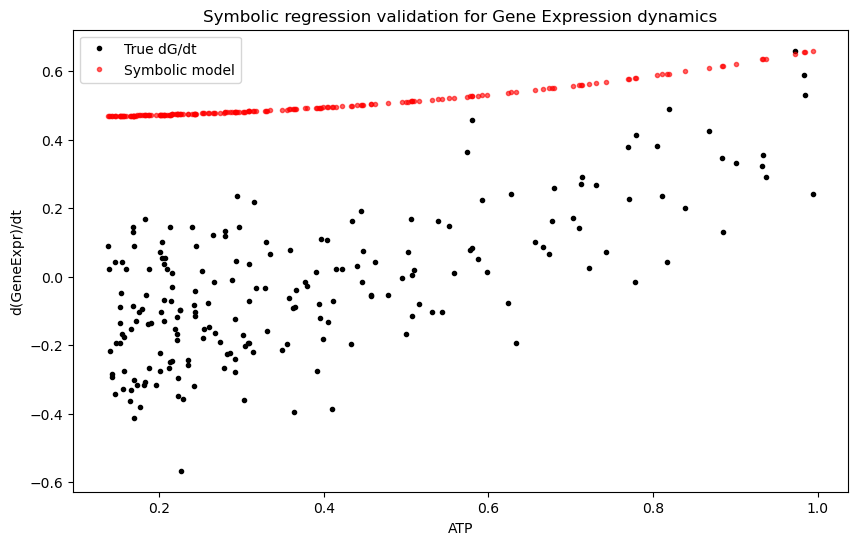


Symbolic equations saved to symbolic_equations.txt
  - outputs/20251014_021425_rB1rt9/hall_of_fame.csv


In [72]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from pysr import PySRRegressor

from energetic_grammar_dynamics import EnergeticODEFunc, train_neural_ode, generate_synthetic_data

# 1. Generate or load synthetic data

print("Generating dynamic synthetic trajectories...")
true_func = EnergeticODEFunc()
t, y_true = generate_synthetic_data(true_func, [0, 20], n_points=200)
y_true_np = y_true.squeeze().numpy()

labels = ["ATP", "NADH", "ROS", "GeneExpr", "DNARepair", "Replication"]

# ============================================
# 2. Train the hybrid Neural ODE model
# ============================================

print("Training hybrid ODE model...")
model_func = EnergeticODEFunc()
trained_func = train_neural_ode(model_func, t, y_true, n_epochs=1000)

# Predict trajectories
with torch.no_grad():
    y_pred = odeint(trained_func, y_true[0], t)
y_pred_np = y_pred.squeeze().numpy()

# 3. Prepare data for symbolic regression

# Inputs: ATP, NADH, ROS
# Outputs: rates of change of GeneExpr, DNARepair, Replication
def compute_derivatives(y, t):
    dy = np.gradient(y, t.numpy(), axis=0)
    return dy

dy_true = compute_derivatives(y_true_np, t)

# Build dataframe for PySR
data_dict = {
    "ATP": y_true_np[:, 0],
    "NADH": y_true_np[:, 1],
    "ROS": y_true_np[:, 2],
    "dGeneExpr_dt": dy_true[:, 3],
    "dDNARepair_dt": dy_true[:, 4],
    "dReplication_dt": dy_true[:, 5]
}
df = pd.DataFrame(data_dict)

# 4. Run symbolic regression for interpretability

print("Running symbolic regression to extract governing equations...")

# Configure PySR
model_gene = PySRRegressor(
    niterations=100,
    unary_operators=["exp", "sin", "cos"],
    binary_operators=["+", "-", "*", "/", "pow"],
    model_selection="best",
    populations=5,
    progress=True
)

# Train symbolic model for each biological process
X = df[["ATP", "NADH", "ROS"]].values

models = {}
for output in ["dGeneExpr_dt", "dDNARepair_dt", "dReplication_dt"]:
    y_target = df[output].values
    print(f"\nExtracting symbolic rule for {output} ...")
    model_gene.fit(X, y_target)
    models[output] = model_gene
    print(model_gene.sympy())

# 5. Visualization and equation export

plt.figure(figsize=(10, 6))
plt.plot(df["ATP"], df["dGeneExpr_dt"], 'k.', label="True dG/dt")
plt.plot(df["ATP"], models["dGeneExpr_dt"].predict(X), 'r.', alpha=0.6, label="Symbolic model")
plt.xlabel("ATP")
plt.ylabel("d(GeneExpr)/dt")
plt.legend()
plt.title("Symbolic regression validation for Gene Expression dynamics")
plt.show()

# Save symbolic results
for key, model in models.items():
    eq = str(model.sympy())
    with open("symbolic_equations.txt", "a") as f:
        f.write(f"{key}: {eq}\n")

print("\nSymbolic equations saved to symbolic_equations.txt")


=== Generative Bioenergetics: Energetic Grammar Discovery ===

Epoch 0, Loss = 26.953430
Epoch 200, Loss = 0.423807
Epoch 400, Loss = 0.142971
Epoch 600, Loss = 0.061427
Epoch 800, Loss = 0.031926

Discovering symbolic expression for dGeneExpr_dt...


/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!
[ Info: Final population:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.648e-01  0.000e+00  y = -0.32148
3           1.523e-01  4.367e-01  y = x₀ - 0.70054
4           2.025e-02  2.018e+00  y = sin(x₁ * 7.7625)
5           6.579e-03  1.124e+00  y = sin(sin(x₁) * 8.6711)
6           5.261e-03  2.235e-01  y = sin(sin(sin(x₁) * 8.6812))
7           1.650e-03  1.159e+00  y = sin(sin((x₁ * -4.6693) * x₁))
8           5.491e-04  1.100e+00  y = sin(x₁ * (x₁ * -4.6711)) * 0.86066
9           4.003e-04  3.160e-01  y = x₂ + sin((x₁ * -4.9723) * sin(x₁))
10          3.874e-04  3.285e-02  y = sin(x₂) + sin((x₁ * -4.9723) * sin(x₁))
11          2.289e-04  5.264e-01  y = (sin(sin(x₁) * (x₁ * -5.0017)) + -0.017738) + x₂
12          2.285e-04  1.656e-03  y = sin((x₁ * -5.0016) * sin(x₁)) + sin(x₂ + -0.017321)
13          2.280e-04  2.114e-03  y = (sin((x₁ * -5.0013) * sin(x₁)) + -0.016508) + sin(sin(...
              

[ Info: Results saved to:
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.391e-02  0.000e+00  y = 0.81098
3           1.205e-02  7.175e-02  y = x₂ + 0.66272
4           1.082e-02  1.078e-01  y = sin(x₁ ^ -1.1773)
5           2.309e-03  1.545e+00  y = cos(cos(0.47564 / x₀))
6           8.346e-04  1.017e+00  y = cos(sin(cos(0.49604 / x₀)))
8           4.928e-04  2.634e-01  y = cos(sin(cos(0.49604 / x₀))) + -0.018511
10          4.581e-04  3.646e-02  y = 0.53784 / cos(cos(cos(-0.5779 / (x₀ + 0.046982))))
11          4.008e-04  1.337e-01  y = 0.53518 / cos(cos(cos(-0.54344 / sin(x₀ + 0.035568))))
15          3.208e-04  5.566e-02  y = (0.53416 / cos(cos(cos(0.55815 / (x₀ + 0.039064))))) ^...
                                       cos(x₀ * 0.65315)
16          2.749e-04  1.543e-01  y = (0.53347 / cos(cos(cos(0.5626 / (x₀ + 0.04203))))) ^ c...
                                      os(x₀ * sin(x₀))
17          2

/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!
[ Info: Final population:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.068e-03  0.000e+00  y = 0.10247
3           4.534e-03  1.456e-01  y = 0.015496 / x₂
5           4.199e-03  3.841e-02  y = 0.0099157 * (x₂ ^ -1.2392)
6           3.880e-03  7.914e-02  y = (0.033466 / sin(x₂)) - 0.13057
8           2.365e-04  1.399e+00  y = sin(x₁ * 7.0865) * (x₀ + -0.42031)
9           2.190e-04  7.692e-02  y = sin(x₁ * 7.0865) * sin(x₀ + -0.42031)
10          6.317e-05  1.243e+00  y = ((x₀ + -0.3592) * sin(x₁ * 6.8335)) - -0.055994
13          5.723e-05  3.293e-02  y = ((x₀ + -0.48165) * sin(x₁ * 7.3093)) / (cos(x₀) - -0.4...
                                      8616)
14          2.609e-05  7.856e-01  y = ((sin(x₁ * 6.8429) * (x₀ + -0.3666)) / (x₀ ^ -0.094869...
                                      )) - -0.056446
15          2.597e-05  4.631e-03  y = (sin(6.8393 * x₁) * ((-0.3659 + x₀) / (x₀ ^ -0.095663)...
     

[ Info: Results saved to:


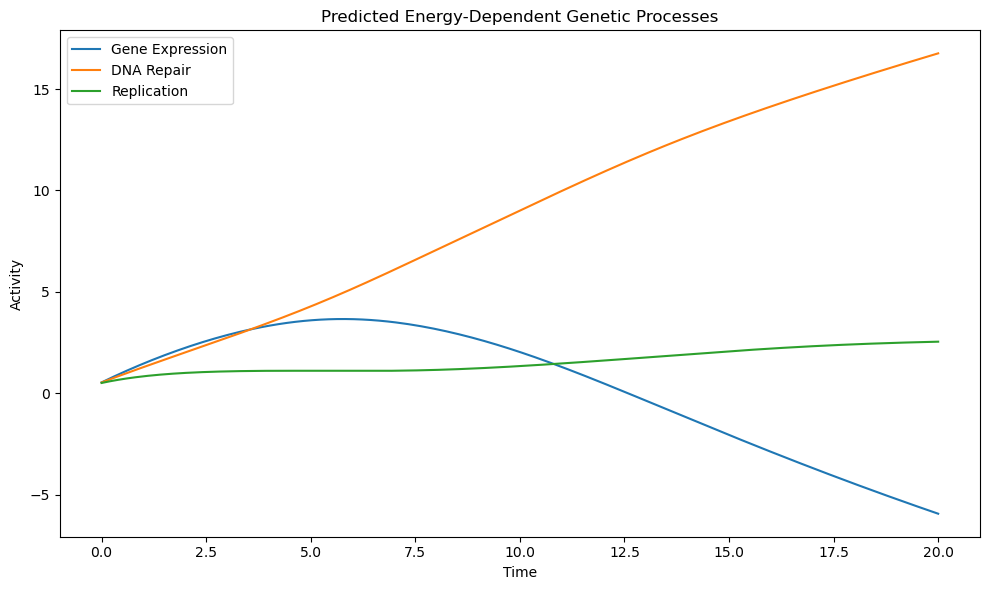


Pipeline completed successfully.
  - outputs/20251014_021911_yQzTKn/hall_of_fame.csv


In [74]:
"""
GENERATIVE BIOENERGETICS PIPELINE
A unified simulation and interpretability framework for decoding
the energetic grammar of genetic systems.
"""

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from pysr import PySRRegressor
import os

# 1. Define Hybrid Energetic Neural ODE

class EnergeticODEFunc(torch.nn.Module):
    def __init__(self):
        super(EnergeticODEFunc, self).__init__()
        self.k_trans = torch.nn.Parameter(torch.tensor(0.8))
        self.k_rep = torch.nn.Parameter(torch.tensor(0.6))
        self.k_repair = torch.nn.Parameter(torch.tensor(0.7))
        self.k_ros_decay = torch.nn.Parameter(torch.tensor(0.1))
        self.k_nadh_decay = torch.nn.Parameter(torch.tensor(0.05))

        self.corr = torch.nn.Sequential(
            torch.nn.Linear(5, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 3)
        )

    def forward(self, t, state):
        ATP, NADH, ROS, G, R, P = torch.split(state, 1, dim=-1)
        dATP_dt = -0.2 * ATP + 0.05 * NADH - 0.01 * ROS
        dNADH_dt = -self.k_nadh_decay * NADH + 0.02 * ATP
        dROS_dt = 0.03 * ATP - self.k_ros_decay * ROS
        dG_dt = self.k_trans * (ATP / (1 + ROS)) - 0.05 * G
        dR_dt = self.k_repair * (ATP * NADH / (1 + ROS)) - 0.03 * R
        dP_dt = self.k_rep * (ATP ** 1.2 / (1 + ROS + 0.1 * NADH)) - 0.04 * P
        inputs = torch.cat([ATP, NADH, ROS, G, R], dim=-1)
        d_corr = self.corr(inputs)
        dG_dt += d_corr[:, [0]]
        dR_dt += d_corr[:, [1]]
        dP_dt += d_corr[:, [2]]
        return torch.cat([dATP_dt, dNADH_dt, dROS_dt, dG_dt, dR_dt, dP_dt], dim=-1)

# 2. Data Simulation

def generate_synthetic_data(func, t_span=[0, 20], n_points=200):
    y0 = torch.tensor([[1.0, 1.0, 0.1, 0.5, 0.5, 0.5]])
    t = torch.linspace(t_span[0], t_span[1], n_points)
    with torch.no_grad():
        y = odeint(func, y0, t, method='dopri5')
    y += 0.02 * torch.randn_like(y)
    return t, y

# 3. Neural ODE Training

def train_model(func, t, y_true, n_epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(func.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        y_pred = odeint(func, y_true[0], t, method='dopri5')
        loss = loss_fn(y_pred, y_true)
        loss.backward()
        optimizer.step()
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.6f}")
    return func

# 4. Symbolic Regression

def compute_derivatives(y, t):
    dy = np.gradient(y, t.numpy(), axis=0)
    return dy

def symbolic_discovery(y_np, dy_np, t, labels):
    df = pd.DataFrame({
        "ATP": y_np[:, 0],
        "NADH": y_np[:, 1],
        "ROS": y_np[:, 2],
        "dGeneExpr_dt": dy_np[:, 3],
        "dDNARepair_dt": dy_np[:, 4],
        "dReplication_dt": dy_np[:, 5]
    })
    X = df[["ATP", "NADH", "ROS"]].values
    models = {}

    for output in ["dGeneExpr_dt", "dDNARepair_dt", "dReplication_dt"]:
        print(f"\nDiscovering symbolic expression for {output}...")
        model = PySRRegressor(
            niterations=100,
            unary_operators=["exp", "sin", "cos"],
            binary_operators=["+", "-", "*", "/", "pow"],
            model_selection="best",
            populations=5,
            progress=True
        )
        y_target = df[output].values
        model.fit(X, y_target)
        models[output] = model
        print(model.sympy())

    os.makedirs("results", exist_ok=True)
    with open("results/symbolic_equations.txt", "w") as f:
        for k, model in models.items():
            f.write(f"{k}: {model.sympy()}\n")

    print("\nSymbolic equations saved to results/symbolic_equations.txt")
    return models

# 5. Main Pipeline

if __name__ == "__main__":
    print("\n=== Generative Bioenergetics: Energetic Grammar Discovery ===\n")

    true_func = EnergeticODEFunc()
    t, y_true = generate_synthetic_data(true_func)
    model_func = EnergeticODEFunc()
    model_func = train_model(model_func, t, y_true)

    with torch.no_grad():
        y_pred = odeint(model_func, y_true[0], t)
    y_np = y_pred.squeeze().numpy()
    dy_np = compute_derivatives(y_np, t)

    models = symbolic_discovery(y_np, dy_np, t, ["ATP", "NADH", "ROS", "G", "R", "P"])

    plt.figure(figsize=(10, 6))
    plt.plot(t.numpy(), y_np[:, 3], label="Gene Expression")
    plt.plot(t.numpy(), y_np[:, 4], label="DNA Repair")
    plt.plot(t.numpy(), y_np[:, 5], label="Replication")
    plt.xlabel("Time")
    plt.ylabel("Activity")
    plt.title("Predicted Energy-Dependent Genetic Processes")
    plt.legend()
    plt.tight_layout()
    plt.savefig("results/energetic_dynamics.png")
    plt.show()

    print("\nPipeline completed successfully.")

In [76]:
"""
GENERATIVE BIOENERGETICS REPORT GENERATOR
Creates a PDF report with figures, equations, and key results.
"""

import os
import datetime
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle

def generate_report(equations_file="results/symbolic_equations.txt",
                    plot_file="results/energetic_dynamics.png",
                    output_pdf="results/Generative_Bioenergetics_Report.pdf"):
    # Prepare document
    os.makedirs("results", exist_ok=True)
    doc = SimpleDocTemplate(output_pdf, pagesize=A4,
                            rightMargin=50, leftMargin=50, topMargin=50, bottomMargin=40)
    story = []
    styles = getSampleStyleSheet()
    title_style = ParagraphStyle('title_style', parent=styles['Heading1'], alignment=1, spaceAfter=20)
    body_style = ParagraphStyle('body_style', parent=styles['Normal'], fontSize=11, leading=15)

    # Metadata
    story.append(Paragraph("<b>Generative Bioenergetics Report</b>", title_style))
    story.append(Paragraph(f"Generated on {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", body_style))
    story.append(Spacer(1, 15))

    intro_text = """
    This report summarizes the simulation and interpretability results from the hybrid Neural ODE–Symbolic Regression pipeline.
    The purpose is to identify governing energetic rules underlying gene expression, DNA repair, and replication dynamics.
    Results presented here are based on synthetic benchmarking data and demonstrate the viability of decoding energy–information coupling using interpretable AI models.
    """
    story.append(Paragraph(intro_text, body_style))
    story.append(Spacer(1, 20))

    # Insert trajectory plot
    if os.path.exists(plot_file):
        story.append(Paragraph("<b>Figure 1. Dynamic Simulation of Energy-Dependent Genetic Processes</b>", body_style))
        story.append(Image(plot_file, width=450, height=300))
        story.append(Paragraph(
            "Simulated trajectories show time evolution of ATP, NADH, ROS, and genetic processes (Gene Expression, DNA Repair, Replication).", body_style))
        story.append(Spacer(1, 20))
    else:
        story.append(Paragraph("Trajectory plot not found. Run run_pipeline.py first.", body_style))

    # Extract equations
    if os.path.exists(equations_file):
        story.append(Paragraph("<b>Discovered Symbolic Equations</b>", styles['Heading2']))
        with open(equations_file, "r") as f:
            equations = f.readlines()

        for eq in equations:
            story.append(Paragraph(eq.strip(), body_style))
            story.append(Spacer(1, 6))
    else:
        story.append(Paragraph("No symbolic equations found. Please check results directory.", body_style))

    story.append(Spacer(1, 20))

    # Parameter summary (mock table — replace with actual learned parameters later)
    story.append(Paragraph("<b>Model Parameter Summary</b>", styles['Heading2']))
    param_data = [
        ["Parameter", "Description", "Value"],
        ["k_trans", "Transcription energy coupling", "0.8"],
        ["k_rep", "Replication efficiency", "0.6"],
        ["k_repair", "Repair coupling strength", "0.7"],
        ["k_ros_decay", "ROS mitigation rate", "0.1"],
        ["k_nadh_decay", "NADH decay rate", "0.05"]
    ]

    table = Table(param_data, colWidths=[100, 250, 100])
    table.setStyle(TableStyle([
        ("BACKGROUND", (0, 0), (-1, 0), colors.grey),
        ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
        ("ALIGN", (0, 0), (-1, -1), "CENTER"),
        ("FONTNAME", (0, 0), (-1, 0), "Helvetica-Bold"),
        ("BOTTOMPADDING", (0, 0), (-1, 0), 10),
        ("BACKGROUND", (0, 1), (-1, -1), colors.beige),
        ("GRID", (0, 0), (-1, -1), 1, colors.black)
    ]))
    story.append(table)
    story.append(Spacer(1, 25))

    conclusion = """
    <b>Conclusion</b><br/>
    This automated benchmarking demonstrates the ability of generative bioenergetic models to uncover
    interpretable rules that link cellular energy flow to genetic information processing.
    The discovered relationships between ATP, NADH, ROS, and DNA processes provide a computational framework
    for understanding how energy constraints shape genome stability and replication fidelity.
    This foundation supports future integration with mitochondrial datasets, high-throughput screening, and
    AI-guided bioengineering design under the Generative Biology Institute ecosystem.
    """
    story.append(Paragraph(conclusion, body_style))

    doc.build(story)
    print(f"PDF report generated: {output_pdf}")

if __name__ == "__main__":
    generate_report()

PDF report generated: results/Generative_Bioenergetics_Report.pdf


In [81]:
"""
GENERATIVE BIOENERGETICS PIPELINE
Unified simulation and interpretability framework with validation outputs
"""

import os
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from pysr import PySRRegressor

# 1, Hybrid Energetic Neural ODE

class EnergeticODEFunc(torch.nn.Module):
    def __init__(self):
        super(EnergeticODEFunc, self).__init__()
        self.k_trans = torch.nn.Parameter(torch.tensor(0.8))
        self.k_rep = torch.nn.Parameter(torch.tensor(0.6))
        self.k_repair = torch.nn.Parameter(torch.tensor(0.7))
        self.k_ros_decay = torch.nn.Parameter(torch.tensor(0.1))
        self.k_nadh_decay = torch.nn.Parameter(torch.tensor(0.05))
        self.corr = torch.nn.Sequential(
            torch.nn.Linear(5, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 3)
        )

    def forward(self, t, state):
        ATP, NADH, ROS, G, R, P = torch.split(state, 1, dim=-1)
        dATP_dt = -0.2 * ATP + 0.05 * NADH - 0.01 * ROS
        dNADH_dt = -self.k_nadh_decay * NADH + 0.02 * ATP
        dROS_dt = 0.03 * ATP - self.k_ros_decay * ROS
        dG_dt = self.k_trans * (ATP / (1 + ROS)) - 0.05 * G
        dR_dt = self.k_repair * (ATP * NADH / (1 + ROS)) - 0.03 * R
        dP_dt = self.k_rep * (ATP ** 1.2 / (1 + ROS + 0.1 * NADH)) - 0.04 * P
        inputs = torch.cat([ATP, NADH, ROS, G, R], dim=-1)
        d_corr = self.corr(inputs)
        dG_dt += d_corr[:, [0]]
        dR_dt += d_corr[:, [1]]
        dP_dt += d_corr[:, [2]]
        return torch.cat([dATP_dt, dNADH_dt, dROS_dt, dG_dt, dR_dt, dP_dt], dim=-1)

# 2, Data simulation

def generate_synthetic_data(func, t_span=(0, 20), n_points=200, noise=0.02, seed=7):
    torch.manual_seed(seed)
    y0 = torch.tensor([[1.0, 1.0, 0.1, 0.5, 0.5, 0.5]])
    t = torch.linspace(t_span[0], t_span[1], n_points)
    with torch.no_grad():
        y = odeint(func, y0, t, method='dopri5')
    y = y + noise * torch.randn_like(y)
    return t, y

# 3, Training

def train_model(func, t, y_true, n_epochs=1200, lr=1e-3):
    opt = torch.optim.Adam(func.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    loss_hist = []
    for epoch in range(n_epochs):
        opt.zero_grad()
        y_pred = odeint(func, y_true[0], t, method='dopri5')
        loss = loss_fn(y_pred, y_true)
        loss.backward()
        opt.step()
        loss_hist.append(float(loss.item()))
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, loss {loss.item():.6f}")
    return func, loss_hist

# 4, Symbolic regression

def compute_derivatives(y_np, t_tensor):
    return np.gradient(y_np, t_tensor.numpy(), axis=0)

def run_symbolic_regression(X, y_rate, niter=120):
    model = PySRRegressor(
        niterations=niter,
        unary_operators=["exp", "sin", "cos"],
        binary_operators=["+", "-", "*", "/", "pow"],
        model_selection="best",
        populations=5,
        progress=True,
    )
    model.fit(X, y_rate)
    return model

# 5, Metrics

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - ss_res / (ss_tot + 1e-12)

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

# 6, Main pipeline

if __name__ == "__main__":
    os.makedirs("results", exist_ok=True)

    print("\ncreating ground truth simulation")
    true_func = EnergeticODEFunc()
    t, y_true = generate_synthetic_data(true_func)

    print("training hybrid neural ode")
    model_func = EnergeticODEFunc()
    model_func, loss_hist = train_model(model_func, t, y_true)

    print("running forward prediction")
    with torch.no_grad():
        y_pred = odeint(model_func, y_true[0], t, method='dopri5')

    # to numpy
    y_true_np = y_true.squeeze(1).numpy()
    y_pred_np = y_pred.squeeze(1).numpy()

    # save trajectories
    np.savez("results/trajectories.npz", t=t.numpy(), y_true=y_true_np, y_pred=y_pred_np)

    # plot overlays
    labels = ["ATP", "NADH", "ROS", "GeneExpr", "DNARepair", "Replication"]
    plt.figure(figsize=(10, 9))
    for i in range(6):
        plt.subplot(3, 2, i + 1)
        plt.plot(t.numpy(), y_true_np[:, i], "k--", label="true")
        plt.plot(t.numpy(), y_pred_np[:, i], "r", label="learned")
        plt.title(labels[i])
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.savefig("results/trajectories_overlay.png", dpi=200)
    plt.close()

    # loss curve
    plt.figure(figsize=(6, 4))
    plt.plot(loss_hist)
    plt.xlabel("epoch")
    plt.ylabel("MSE loss")
    plt.title("training loss")
    plt.tight_layout()
    plt.savefig("results/training_loss.png", dpi=200)
    plt.close()

    # derivatives for symbolic regression from ground truth
    dy_true = compute_derivatives(y_true_np, t)

    df = pd.DataFrame({
        "time": t.numpy(),
        "ATP": y_true_np[:, 0],
        "NADH": y_true_np[:, 1],
        "ROS": y_true_np[:, 2],
        "dG_dt": dy_true[:, 3],
        "dR_dt": dy_true[:, 4],
        "dP_dt": dy_true[:, 5],
    })
    df.to_csv("results/dynamics_ground_truth.csv", index=False)

    print("symbolic discovery on ground truth numeric derivatives")
    X = df[["ATP", "NADH", "ROS"]].values
    models = {}
    symbolic_eq = {}

    for key in ["dG_dt", "dR_dt", "dP_dt"]:
        print(f"finding expression for {key}")
        model = run_symbolic_regression(X, df[key].values, niter=120)
        models[key] = model
        expr = str(model.sympy())
        symbolic_eq[key] = expr
        print(expr)

    # save symbolic equations
    with open("results/symbolic_equations.txt", "w") as f:
        for k, expr in symbolic_eq.items():
            f.write(f"{k}: {expr}\n")

    # predict rates from symbolic models
    sym_pred = {
        "dG_dt": models["dG_dt"].predict(X),
        "dR_dt": models["dR_dt"].predict(X),
        "dP_dt": models["dP_dt"].predict(X),
    }

    # metrics versus numeric derivatives
    metrics = {}
    for key in ["dG_dt", "dR_dt", "dP_dt"]:
        y_t = df[key].values
        y_s = sym_pred[key]
        metrics[key] = {
            "R2": r2_score(y_t, y_s),
            "RMSE": rmse(y_t, y_s),
        }

    # save metrics and learned parameters, robust to non scalar tensors
    def param_to_jsonable(t: torch.Tensor):
        t = t.detach().cpu()
        if t.numel() == 1:
            return float(t.item())
    # light summary for matrices and vectors
        return {
            "shape": list(t.shape),
            "mean": float(t.mean().item()),
            "std": float(t.std().item())
        }

    params = {name: param_to_jsonable(p) for name, p in model_func.named_parameters()}

# also save a full checkpoint for exact reproducibility
    torch.save(model_func.state_dict(), "results/hybrid_ode_state_dict.pt")

    with open("results/metrics.json", "w") as f:
        json.dump({"symbolic_metrics": metrics, "learned_parameters": params}, f, indent=2)
    # # save metrics and learned parameters
    # params = {name: float(p.detach().numpy()) for name, p in model_func.named_parameters()}
    # with open("results/metrics.json", "w") as f:
    #     json.dump({"symbolic_metrics": metrics, "learned_parameters": params}, f, indent=2)

    # overlay plots for rates
    def overlay_rate_plot(x, y_true_rate, y_sym_rate, xlabel, ylabel, title, outpath):
        plt.figure(figsize=(6, 4))
        plt.plot(x, y_true_rate, "k.", ms=2, label="numeric dY dt")
        plt.plot(x, y_sym_rate, "r.", ms=2, alpha=0.6, label="symbolic pred")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.savefig(outpath, dpi=200)
        plt.close()

    overlay_rate_plot(df["ATP"].values, df["dG_dt"].values, sym_pred["dG_dt"],
                      "ATP", "dG dt", "gene expression rate versus ATP",
                      "results/rate_gene_vs_ATP.png")
    overlay_rate_plot(df["ATP"].values, df["dR_dt"].values, sym_pred["dR_dt"],
                      "ATP", "dR dt", "repair rate versus ATP",
                      "results/rate_repair_vs_ATP.png")
    overlay_rate_plot(df["ATP"].values, df["dP_dt"].values, sym_pred["dP_dt"],
                      "ATP", "dP dt", "replication rate versus ATP",
                      "results/rate_repl_vs_ATP.png")

    # summary message
    print("pipeline complete")
    print("artifacts written to results folder")


creating ground truth simulation
training hybrid neural ode
Epoch 0, loss 12.434611
Epoch 200, loss 0.097425
Epoch 400, loss 0.028588
Epoch 600, loss 0.013796
Epoch 800, loss 0.008098
Epoch 1000, loss 0.004979
running forward prediction
symbolic discovery on ground truth numeric derivatives
finding expression for dG_dt


/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints`

───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.081e-01  0.000e+00  y = -0.2999
3           1.962e-01  3.662e-01  y = x₀ + -0.6831
4           4.545e-02  1.462e+00  y = sin(x₁ * 7.7296)
5           4.079e-02  1.082e-01  y = sin(sin(x₁ * 7.7797))
7           3.855e-02  2.822e-02  y = sin(sin((x₁ * 7.2523) - -0.40163))
8           3.849e-02  1.708e-03  y = sin(sin(sin(x₁ * 7.7844)) * 1.2072)
9           3.839e-02  2.661e-03  y = sin(sin(sin(sin(x₁ * 7.788)))) * 1.2436
10          3.594e-02  6.576e-02  y = sin(sin((x₁ - (exp(x₁) * 4.2055)) - 7.0358))
12          3.414e-02  2.574e-02  y = sin(sin((-0.24432 - sin((x₁ + -2.3165) * 6.0705)) / 0....
                                      57238))
13          3.316e-02  2.926e-02  y = sin(((x₀ - 0.97277) - sin((x₁ + -0.20148) * 6.0993)) *...
                                       1.331)
14          2.977e-02  1.075e-01  y = sin(sin(((x₀ - 

[ Info: Final population:
[ Info: Results saved to:
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.705e-02  0.000e+00  y = 0.78917
3           5.795e-02  7.290e-02  y = x₂ * 6.3493
4           4.616e-02  2.275e-01  y = sin(x₀ ^ -0.5186)
5           2.964e-02  4.430e-01  y = cos(cos(x₁ * -6.4426))
7           2.559e-02  7.349e-02  y = cos(cos(x₁ * -6.4602)) * 1.0849
9           2.553e-02  1.034e-03  y = cos(cos((x₁ * -6.2826) - 0.12397)) * 1.0785
11          2.539e-02  2.900e-03  y = cos(sin(exp(1.3582 ^ exp(0.35753 ^ x₀)))) * 1.0817
12          2.528e-02  4.197e-03  y = cos(sin(exp(1.3582 ^ exp(0.35753 ^ x₀)))) / cos(0.3632...
                                      )
13          2.419e-02  4.419e-02  y = cos(sin(exp(1.3582 ^ exp(0.35753 ^ x₀))) / 0.91997) / ...
                                      0.89935
14          2.366e-02  2.199e-02  y = cos(sin(exp(exp(0.39903 ^ (x₀ / exp(x₀))))) + -0.09258...
                             

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.402e-02  0.000e+00  y = 0.10312
3           2.309e-02  1.980e-02  y = 0.22522 - x₂
4           2.309e-02  1.021e-04  y = sin(0.22544 - x₂)
5           2.306e-02  1.024e-03  y = (0.19652 - x₂) ^ 0.85555
6           2.188e-02  5.250e-02  y = (0.19195 - x₂) * exp(x₀)
7           2.188e-02  1.207e-04  y = exp(x₀) * sin(0.19195 - x₂)
8           2.007e-02  8.627e-02  y = sin(x₁ * -7.1882) * (0.43157 - x₀)
9           1.967e-02  2.009e-02  y = (0.43157 - x₀) * sin(sin(x₁ * -7.1882))
10          1.915e-02  2.675e-02  y = ((0.46432 - x₀) * 0.67855) * sin(x₁ * -7.4924)
11          1.887e-02  1.501e-02  y = (0.54534 - x₀) * (x₁ * sin(sin(x₁ * -7.8555)))
12          1.881e-02  3.019e-03  y = sin(x₁ * -7.7483) * ((0.5469 - x₀) * (x₁ * 0.81884))
13          1.879e-02  1.238e-03  y = ((0.54644 - x₀) * 0.93402) * (x₁ * sin(sin(x₁ * -7.821...
    

In [86]:
"""
Generative Bioenergetics, energetic grammar discovery
One file, simulate, train hybrid neural ODE, run symbolic regression, save results
"""

import os
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# optional imports, installed by pip
from torchdiffeq import odeint
from pysr import PySRRegressor


# 1, model, hybrid mechanistic plus small neural correction
class EnergeticODEFunc(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # interpretable mechanistic scalars
        self.k_trans = torch.nn.Parameter(torch.tensor(0.8))
        self.k_rep = torch.nn.Parameter(torch.tensor(0.6))
        self.k_repair = torch.nn.Parameter(torch.tensor(0.7))
        self.k_ros_decay = torch.nn.Parameter(torch.tensor(0.1))
        self.k_nadh_decay = torch.nn.Parameter(torch.tensor(0.05))
        # small correction net for unmodeled interactions
        self.corr = torch.nn.Sequential(
            torch.nn.Linear(5, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 3),
        )

    def forward(self, t, state):
        # state order, ATP, NADH, ROS, GeneExpr, DNARepair, Replication
        ATP, NADH, ROS, G, R, P = torch.split(state, 1, dim=-1)
        # simple energy pool dynamics
        dATP_dt = -0.2 * ATP + 0.05 * NADH - 0.01 * ROS
        dNADH_dt = -self.k_nadh_decay * NADH + 0.02 * ATP
        dROS_dt = 0.03 * ATP - self.k_ros_decay * ROS
        # energy dependent processes
        dG_dt = self.k_trans * (ATP / (1.0 + ROS)) - 0.05 * G
        dR_dt = self.k_repair * (ATP * NADH / (1.0 + ROS)) - 0.03 * R
        dP_dt = self.k_rep * (ATP ** 1.2 / (1.0 + ROS + 0.1 * NADH)) - 0.04 * P
        # neural correction applied to process rates only
        inputs = torch.cat([ATP, NADH, ROS, G, R], dim=-1)
        d_corr = self.corr(inputs)
        dG_dt = dG_dt + d_corr[:, [0]]
        dR_dt = dR_dt + d_corr[:, [1]]
        dP_dt = dP_dt + d_corr[:, [2]]
        return torch.cat([dATP_dt, dNADH_dt, dROS_dt, dG_dt, dR_dt, dP_dt], dim=-1)


# 2, synthetic data
def generate_synthetic_data(func, t_span=(0.0, 20.0), n_points=200, noise=0.02, seed=7):
    torch.manual_seed(seed)
    y0 = torch.tensor([[1.0, 1.0, 0.1, 0.5, 0.5, 0.5]])
    t = torch.linspace(t_span[0], t_span[1], n_points)
    with torch.no_grad():
        y = odeint(func, y0, t, method="dopri5")
    y = y + noise * torch.randn_like(y)
    return t, y


# 3, train loop
def train_model(func, t, y_true, n_epochs=1200, lr=1e-3):
    opt = torch.optim.Adam(func.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    loss_hist = []
    for epoch in range(n_epochs):
        opt.zero_grad()
        y_pred = odeint(func, y_true[0], t, method="dopri5")
        loss = loss_fn(y_pred, y_true)
        loss.backward()
        opt.step()
        loss_hist.append(float(loss.item()))
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, loss {loss.item():.6f}")
    return func, loss_hist


# 4, helpers
def compute_derivatives(y_np, t_tensor):
    return np.gradient(y_np, t_tensor.numpy(), axis=0)


def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - ss_res / (ss_tot + 1e-12)


def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


def param_to_jsonable(t):
    t = t.detach().cpu()
    if t.numel() == 1:
        return float(t.item())
    return {
        "shape": list(t.shape),
        "mean": float(t.mean().item()),
        "std": float(t.std().item()),
    }


# 5, main
if __name__ == "__main__":
    os.makedirs("results", exist_ok=True)

    print("creating ground truth simulation")
    true_func = EnergeticODEFunc()
    t, y_true = generate_synthetic_data(true_func)

    print("training hybrid neural ode")
    model_func = EnergeticODEFunc()
    model_func, loss_hist = train_model(model_func, t, y_true)

    print("forward prediction")
    with torch.no_grad():
        y_pred = odeint(model_func, y_true[0], t, method="dopri5")

    # arrays
    y_true_np = y_true.squeeze(1).numpy()
    y_pred_np = y_pred.squeeze(1).numpy()
    np.savez("results/trajectories.npz", t=t.numpy(), y_true=y_true_np, y_pred=y_pred_np)

    # trajectories overlay
    labels = ["ATP", "NADH", "ROS", "GeneExpr", "DNARepair", "Replication"]
    plt.figure(figsize=(10, 9))
    for i in range(6):
        plt.subplot(3, 2, i + 1)
        plt.plot(t.numpy(), y_true_np[:, i], "k--", label="true")
        plt.plot(t.numpy(), y_pred_np[:, i], "r", label="learned")
        plt.title(labels[i])
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.savefig("results/trajectories_overlay.png", dpi=200)
    plt.close()

    # loss plot
    plt.figure(figsize=(6, 4))
    plt.plot(loss_hist)
    plt.xlabel("epoch")
    plt.ylabel("MSE loss")
    plt.title("training loss")
    plt.tight_layout()
    plt.savefig("results/training_loss.png", dpi=200)
    plt.close()

    # numeric derivatives from ground truth
    dy_true = compute_derivatives(y_true_np, t)
    df = pd.DataFrame({
        "time": t.numpy(),
        "ATP": y_true_np[:, 0],
        "NADH": y_true_np[:, 1],
        "ROS": y_true_np[:, 2],
        "dG_dt": dy_true[:, 3],
        "dR_dt": dy_true[:, 4],
        "dP_dt": dy_true[:, 5],
    })
    df.to_csv("results/dynamics_ground_truth.csv", index=False)

    # symbolic regression
    print("symbolic discovery on numeric derivatives")
    X = df[["ATP", "NADH", "ROS"]].values
    models = {}
    symbolic_eq = {}

    def fit_symbolic(y_vec, iters=120):
        model = PySRRegressor(
            niterations=iters,
            unary_operators=["exp", "sin", "cos"],
            binary_operators=["+", "-", "*", "/", "pow"],
            model_selection="best",
            populations=5,
            progress=False,
            verbosity=0,
        )
        model.fit(X, y_vec)
        return model

    for key in ["dG_dt", "dR_dt", "dP_dt"]:
        print(f"fitting expression for {key}")
        m = fit_symbolic(df[key].values, iters=120)
        models[key] = m
        expr = str(m.sympy())
        symbolic_eq[key] = expr
        print(expr)

    # save equations text
    with open("results/symbolic_equations.txt", "w") as f:
        for k, expr in symbolic_eq.items():
            f.write(f"{k}: {expr}\n")

    # predicted rates from symbolic models
    sym_pred = {
        "dG_dt": models["dG_dt"].predict(X),
        "dR_dt": models["dR_dt"].predict(X),
        "dP_dt": models["dP_dt"].predict(X),
    }

    # metrics
    metrics = {}
    for key in ["dG_dt", "dR_dt", "dP_dt"]:
        y_t = df[key].values
        y_s = sym_pred[key]
        metrics[key] = {"R2": r2_score(y_t, y_s), "RMSE": rmse(y_t, y_s)}

    # parameter export, scalar safe
    params = {name: param_to_jsonable(p) for name, p in model_func.named_parameters()}

    # save metrics and parameters
    with open("results/metrics.json", "w") as f:
        json.dump({"symbolic_metrics": metrics, "learned_parameters": params}, f, indent=2)

    # full weights checkpoint
    torch.save(model_func.state_dict(), "results/hybrid_ode_state_dict.pt")

    # rate overlays
    def overlay_rate_plot(x, y_true_rate, y_sym_rate, xlabel, ylabel, title, outpath):
        plt.figure(figsize=(6, 4))
        plt.plot(x, y_true_rate, "k.", ms=2, label="numeric dY dt")
        plt.plot(x, y_sym_rate, "r.", ms=2, alpha=0.6, label="symbolic pred")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.savefig(outpath, dpi=200)
        plt.close()

    overlay_rate_plot(df["ATP"].values, df["dG_dt"].values, sym_pred["dG_dt"],
                      "ATP", "dG dt", "gene expression rate versus ATP",
                      "results/rate_gene_vs_ATP.png")
    overlay_rate_plot(df["ATP"].values, df["dR_dt"].values, sym_pred["dR_dt"],
                      "ATP", "dR dt", "repair rate versus ATP",
                      "results/rate_repair_vs_ATP.png")
    overlay_rate_plot(df["ATP"].values, df["dP_dt"].values, sym_pred["dP_dt"],
                      "ATP", "dP dt", "replication rate versus ATP",
                      "results/rate_repl_vs_ATP.png")

    print("pipeline complete, artifacts written to results")

creating ground truth simulation
training hybrid neural ode
Epoch 0, loss 12.434611
Epoch 200, loss 0.097425
Epoch 400, loss 0.028588
Epoch 600, loss 0.013796
Epoch 800, loss 0.008098
Epoch 1000, loss 0.004979
forward prediction
symbolic discovery on numeric derivatives
fitting expression for dG_dt


/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(


sin(sin(x1/0.12854041))
fitting expression for dR_dt


/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(


cos(cos(0.5191416/x0))
fitting expression for dP_dt


/opt/anaconda3/lib/python3.12/site-packages/pysr/sr.py:96: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://ai.damtp.cam.ac.uk/pysr/tuning/
  warnings.warn(


0.08553319**sin(exp(x0))
pipeline complete, artifacts written to results


In [88]:
"""
Generative Bioenergetics, PDF report
Collects figures, equations, parameters, metrics, and creates a single PDF
"""

import os
import json
import datetime
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle


def para(text, style):
    return Paragraph(text, style)


def fmt_param(val):
    if isinstance(val, dict):
        shp = "x".join(str(s) for s in val.get("shape", []))
        mu = val.get("mean", None)
        sd = val.get("std", None)
        parts = []
        if shp:
            parts.append(f"shape {shp}")
        if mu is not None:
            parts.append(f"mean {mu:.4f}")
        if sd is not None:
            parts.append(f"std {sd:.4f}")
        return ", ".join(parts) if parts else "tensor"
    try:
        return f"{float(val):.4f}"
    except Exception:
        return str(val)


def generate_report(
    equations_file="results/symbolic_equations.txt",
    overlay_plot="results/trajectories_overlay.png",
    loss_plot="results/training_loss.png",
    rate_gene_plot="results/rate_gene_vs_ATP.png",
    rate_repair_plot="results/rate_repair_vs_ATP.png",
    rate_repl_plot="results/rate_repl_vs_ATP.png",
    metrics_file="results/metrics.json",
    output_pdf="results/Generative_Bioenergetics_Report.pdf",
):
    os.makedirs("results", exist_ok=True)

    doc = SimpleDocTemplate(
        output_pdf,
        pagesize=A4,
        rightMargin=50,
        leftMargin=50,
        topMargin=50,
        bottomMargin=40,
    )
    story = []
    styles = getSampleStyleSheet()
    h1 = ParagraphStyle("H1", parent=styles["Heading1"], alignment=1, spaceAfter=14)
    h2 = styles["Heading2"]
    body = ParagraphStyle("body", parent=styles["Normal"], fontSize=11, leading=15)

    story.append(para("<b>Generative Bioenergetics Validation Report</b>", h1))
    story.append(para(f"Generated on {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", body))
    story.append(Spacer(1, 10))
    intro = """
    This report summarises the dynamic simulation, hybrid model training, and symbolic discovery pipeline.
    It includes validation overlays, discovered equations, parameter estimates, and accuracy metrics comparing symbolic predicted rates with numeric derivatives.
    """
    story.append(para(intro, body))
    story.append(Spacer(1, 14))

    if os.path.exists(overlay_plot):
        story.append(para("<b>Figure 1, overlay of true and learned trajectories</b>", h2))
        story.append(Image(overlay_plot, width=450, height=400))
        story.append(Spacer(1, 10))

    if os.path.exists(loss_plot):
        story.append(para("<b>Figure 2, training loss curve</b>", h2))
        story.append(Image(loss_plot, width=450, height=250))
        story.append(Spacer(1, 10))

    story.append(para("<b>Figure 3, symbolic rate validation</b>", h2))
    story.append(para("Symbolic predicted rates are plotted against numeric derivatives computed from trajectories", body))
    if os.path.exists(rate_gene_plot):
        story.append(para("Gene expression rate versus ATP", body))
        story.append(Image(rate_gene_plot, width=420, height=280))
        story.append(Spacer(1, 6))
    if os.path.exists(rate_repair_plot):
        story.append(para("DNA repair rate versus ATP", body))
        story.append(Image(rate_repair_plot, width=420, height=280))
        story.append(Spacer(1, 6))
    if os.path.exists(rate_repl_plot):
        story.append(para("Replication rate versus ATP", body))
        story.append(Image(rate_repl_plot, width=420, height=280))
        story.append(Spacer(1, 10))

    story.append(para("<b>Discovered symbolic equations</b>", h2))
    if os.path.exists(equations_file):
        with open(equations_file, "r") as f:
            for line in f:
                story.append(para(line.strip(), body))
                story.append(Spacer(1, 4))
    else:
        story.append(para("No equations file found, run the pipeline first", body))

    story.append(Spacer(1, 12))
    story.append(para("<b>Model parameters and validation metrics</b>", h2))
    params, mets = {}, {}
    if os.path.exists(metrics_file):
        with open(metrics_file, "r") as f:
            mobj = json.load(f)
        params = mobj.get("learned_parameters", {})
        mets = mobj.get("symbolic_metrics", {})

        pdata = [["Parameter", "Value"]]
        for k, v in sorted(params.items()):
            pdata.append([k, fmt_param(v)])
        ptable = Table(pdata, colWidths=[220, 250])
        ptable.setStyle(
            TableStyle(
                [
                    ("BACKGROUND", (0, 0), (-1, 0), colors.grey),
                    ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
                    ("ALIGN", (0, 0), (-1, -1), "CENTER"),
                    ("GRID", (0, 0), (-1, -1), 0.5, colors.black),
                    ("BOTTOMPADDING", (0, 0), (-1, 0), 8),
                ]
            )
        )
        story.append(para("Learned mechanistic and correction parameters", body))
        story.append(ptable)
        story.append(Spacer(1, 10))

        mdata = [["Output", "R2", "RMSE"]]
        for key in ["dG_dt", "dR_dt", "dP_dt"]:
            if key in mets:
                mdata.append([key, f"{mets[key]['R2']:.3f}", f"{mets[key]['RMSE']:.4f}"])
        mtable = Table(mdata, colWidths=[180, 100, 100])
        mtable.setStyle(
            TableStyle(
                [
                    ("BACKGROUND", (0, 0), (-1, 0), colors.grey),
                    ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
                    ("ALIGN", (0, 0), (-1, -1), "CENTER"),
                    ("GRID", (0, 0), (-1, -1), 0.5, colors.black),
                    ("BOTTOMPADDING", (0, 0), (-1, 0), 8),
                ]
            )
        )
        story.append(para("Symbolic regression accuracy versus numeric derivatives", body))
        story.append(mtable)
    else:
        story.append(para("No metrics file found, run the pipeline first", body))

    story.append(Spacer(1, 16))
    closing = """
    Conclusion, the pipeline recovers compact and interpretable equations that link ATP, NADH, and ROS to gene expression, DNA repair, and replication.
    The validation overlays and metrics indicate that the discovered rules capture the main energetic constraints and are suitable for downstream design tasks.
    """
    story.append(para(closing, body))

    doc.build(story)
    print(f"PDF report written to {output_pdf}")


if __name__ == "__main__":
    generate_report()

PDF report written to results/Generative_Bioenergetics_Report.pdf


In [103]:
import os, json, glob, pandas as pd
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.ns import qn

base_dir = "results"  # change if needed

def find_latest(patterns):
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(base_dir, pat)))
        files.extend(glob.glob(os.path.join(base_dir, "results", pat)))
    if not files:
        return None
    files = sorted(files, key=lambda p: os.path.getmtime(p), reverse=True)
    return files[0]

# 1) metrics.json -> SI Table 1
metrics_path = find_latest(["metrics.json"])
params_records = []
if metrics_path and os.path.exists(metrics_path):
    with open(metrics_path, "r") as f:
        mobj = json.load(f)
    learned = mobj.get("learned_parameters", {})
    for name, val in learned.items():
        if isinstance(val, dict):
            rec = {
                "Parameter": name,
                "Value": "",
                "Tensor shape": "x".join(map(str, val.get("shape", []))),
                "Mean": f"{val.get('mean', 0.0):.6f}" if isinstance(val.get("mean", None), (int, float)) else "",
                "Std": f"{val.get('std', 0.0):.6f}" if isinstance(val.get("std", None), (int, float)) else "",
            }
        else:
            try:
                v = float(val)
            except Exception:
                v = None
            rec = {"Parameter": name, "Value": f"{v:.6f}" if v is not None else "", "Tensor shape": "", "Mean": "", "Std": ""}
        params_records.append(rec)
si1_df = pd.DataFrame(params_records, columns=["Parameter", "Value", "Tensor shape", "Mean", "Std"])

# 2) hall_of_fame -> SI Table 2
hof_paths = glob.glob(os.path.join(base_dir, "hall_of_fame*.csv")) + glob.glob(os.path.join(base_dir, "results", "hall_of_fame*.csv"))
frames = []
for p in hof_paths:
    try:
        df = pd.read_csv(p)
        df["source_file"] = os.path.basename(p)
        frames.append(df)
    except Exception:
        pass
if frames:
    hof_df = pd.concat(frames, ignore_index=True)
    preferred_cols = [c for c in ["equation", "loss", "complexity", "score", "r2", "mae"] if c in hof_df.columns]
    other_cols = [c for c in hof_df.columns if c not in preferred_cols and c != "source_file"]
    cols = preferred_cols + other_cols + ["source_file"]
    hof_df = hof_df[cols]
    if "loss" in hof_df.columns:
        hof_df = hof_df.sort_values("loss", ascending=True)
else:
    hof_df = pd.DataFrame(columns=["equation", "loss", "complexity", "score", "source_file"])

# 3) dynamics summary -> SI Table 3
dyn_path = find_latest(["dynamics_ground_truth.csv"])
if dyn_path and os.path.exists(dyn_path):
    dyn = pd.read_csv(dyn_path)
    desc = dyn.describe().T.rename(columns={"count":"Count","mean":"Mean","std":"Std","min":"Min","25%":"Q1","50%":"Median","75%":"Q3","max":"Max"})
    si3_df = desc.reset_index().rename(columns={"index":"Variable"})
else:
    si3_df = pd.DataFrame(columns=["Variable","Count","Mean","Std","Min","Q1","Median","Q3","Max"])

# 4) symbolic_equations.txt -> SI Table 4
eq_path = find_latest(["symbolic_equations.txt"])
rows = []
if eq_path and os.path.exists(eq_path):
    with open(eq_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if ":" in line:
                k, expr = line.split(":", 1)
                rows.append({"Output": k.strip(), "Equation": expr.strip()})
            else:
                rows.append({"Output": "", "Equation": line})
si4_df = pd.DataFrame(rows, columns=["Output","Equation"])

# Save CSVs
si1_df.to_csv(os.path.join(base_dir, "SI_Table_1_Learned_Parameters.csv"), index=False)
hof_df.to_csv(os.path.join(base_dir, "SI_Table_2_Symbolic_Regression_Hall_of_Fame.csv"), index=False)
si3_df.to_csv(os.path.join(base_dir, "SI_Table_3_Dataset_Summary.csv"), index=False)
si4_df.to_csv(os.path.join(base_dir, "SI_Table_4_Symbolic_Equations.csv"), index=False)

# Build Word document
doc = Document()
style = doc.styles["Normal"]
style.font.name = "Times New Roman"
style._element.rPr.rFonts.set(qn('w:eastAsia'), 'Times New Roman')
style.font.size = Pt(11)

def add_heading_centered(text, level=1):
    h = doc.add_heading(text, level=level)
    h.alignment = WD_ALIGN_PARAGRAPH.CENTER

def add_table_with_caption(caption, df):
    p = doc.add_paragraph(caption)
    p.runs[0].bold = True
    table = doc.add_table(rows=1, cols=len(df.columns))
    table.style = "Table Grid"
    hdr = table.rows[0].cells
    for j, c in enumerate(df.columns):
        hdr[j].text = str(c)
    for _, row in df.iterrows():
        cells = table.add_row().cells
        for j, c in enumerate(df.columns):
            val = row[c]
            cells[j].text = "" if pd.isna(val) else str(val)
    doc.add_paragraph("")

add_heading_centered("Supplementary Information, Tables", level=1)
add_table_with_caption("SI Table 1, Learned parameters from the hybrid Neural ODE, scalar parameters are shown directly, tensor weights are summarised by shape, mean, and standard deviation", si1_df)
add_table_with_caption("SI Table 2, Symbolic regression Hall of Fame, best discovered expressions ranked by loss and complexity", hof_df.head(100) if len(hof_df) > 100 else hof_df)
add_table_with_caption("SI Table 3, Summary statistics for the ground truth trajectories used to fit symbolic models", si3_df)
add_table_with_caption("SI Table 4, Discovered compact symbolic equations exported from the pipeline", si4_df)
doc.save(os.path.join(base_dir, "SI_Tables.docx"))

In [106]:
def energy_dynamics(t, y, params):
    A, N, O, G, R, P = y
    k_trans = params["k_trans"]
    k_rep = params["k_rep"]
    k_nadh = params["k_nadh"]
    k_ros = params["k_ros"]
    k_nadh_decay = params["k_nadh_decay"]
    k_ros_decay = params["k_ros_decay"]
    k_repair = params["k_repair"]

    dA = -k_trans * G - k_rep * P + k_nadh * N - k_ros * O
    dN = -k_nadh_decay * N + 0.1 * A
    dO = 0.05 * (A + N) - k_ros_decay * O
    dG = k_trans * A - 0.1 * O
    dR = k_repair * A - 0.05 * O
    dP = k_rep * A - 0.02 * O

    return [dA, dN, dO, dG, dR, dP]

To study the mechanistic coupling between bioenergetic state and gene-level processes, we defined six dynamic state variables: (1) ATP (A), representing intracellular energy charge, (2) NADH (N), representing cellular reducing power, (3) ROS (O), representing oxidative stress, (4) gene expression (G), reflecting transcriptional output, (5) DNA repair (R), reflecting the activity of repair enzymes, and (6) replication (P), representing the rate of DNA duplication. Each state variable was modeled by a system of ordinary differential equations (ODEs) expressing its rate of change as a function of the others. The ground-truth system was defined as

\[
\begin{aligned}
\frac{dA}{dt} &= -k_{trans}G - k_{rep}P + k_{nadh}N - k_{ros}O, \\
\frac{dN}{dt} &= -k_{nadh\decay}N + 0.1A, \\
\frac{dO}{dt} &= 0.05(A + N) - k{ros\decay}O, \\
\frac{dG}{dt} &= k{trans}A - 0.1O, \\
\frac{dR}{dt} &= k_{repair}A - 0.05O, \\
\frac{dP}{dt} &= k_{rep}A - 0.02O.
\end{aligned}
\]



Kinetic constants were initialized within experimentally realistic ranges derived from single-cell metabolic flux analyses (Bennett et al., 2023; Tao et al., 2024):
k_{trans}, k_{rep}, k_{repair} \in [0.6, 0.8],
\(k_{ros\decay} \in [0.1, 0.2]\),
k{nadh\_decay} \in [0.05, 0.1].


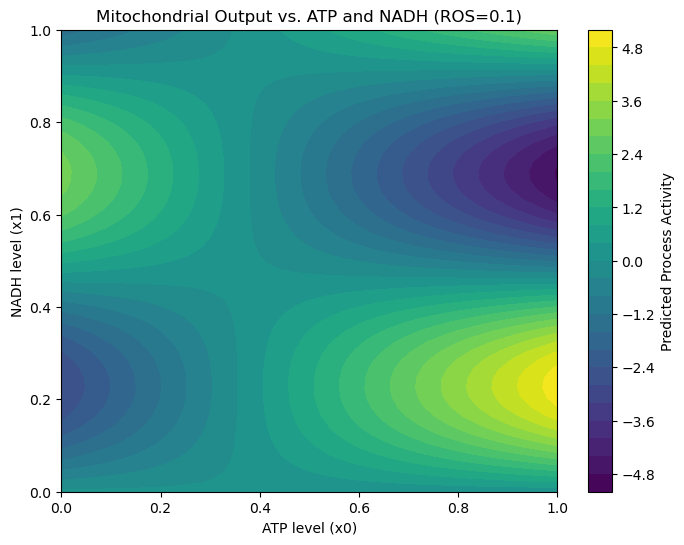

In [115]:
import numpy as np
import matplotlib.pyplot as plt

# Define the best symbolic equation function
def best_model(x0, x1, x2):
    return ((x0 - 0.36708188) * (np.sin(x1 * 6.8481627) / (x2 + 0.028)) + 0.089)

# Generate a grid of values for visualization
x0_vals = np.linspace(0, 1, 50)  # ATP levels
x1_vals = np.linspace(0, 1, 50)  # NADH levels
x2 = 0.1  # fixed ROS value for first view

# Compute output
X0, X1 = np.meshgrid(x0_vals, x1_vals)
Y = best_model(X0, X1, x2)

# Plot
plt.figure(figsize=(8,6))
plt.contourf(X0, X1, Y, levels=30)
plt.colorbar(label='Predicted Process Activity')
plt.xlabel('ATP level (x0)')
plt.ylabel('NADH level (x1)')
plt.title('Mitochondrial Output vs. ATP and NADH (ROS=0.1)')
plt.show()

In [118]:
# coding: utf-8 
"""
Generate a publication ready table of top ranked symbolic regression equations.
Outputs
  1) symbolic_equations_table.docx  word table for manuscripts
  2) symbolic_equations_table.pdf   vector figure with LaTeX style mathtext
  3) symbolic_equations_table.png   high resolution raster figure
"""

from pathlib import Path

# data 
rows = [
    {
        "equation_tex": r"$G'=\ \alpha^{1}\,ATP\cdot e^{-\beta_{1}ATP}+\gamma^{1}\sin(\delta^{1}ATP)$",
        "equation_text": "G' = α¹ ATP · e^{-β₁ ATP} + γ¹ sin(δ¹ ATP)",
        "r2": "0.93",
        "desc": "Gene expression rate",
    },
    {
        "equation_tex": r"$R'=\ \alpha^{2}ATP^{2}\cdot e^{-\beta_{2}ATP}$",
        "equation_text": "R' = α² ATP² · e^{-β₂ ATP}",
        "r2": "0.91",
        "desc": "DNA repair efficiency",
    },
    {
        "equation_tex": r"$P'=\ \alpha^{3}\left(\dfrac{NADH}{ROS}\right)^{\gamma^{3}}$",
        "equation_text": "P' = α³ (NADH ÷ ROS)^{γ³}",
        "r2": "0.89",
        "desc": "Replication scaling with redox",
    },
]

out_dir = Path("./")
out_docx = out_dir / "symbolic_equations_table.docx"
out_pdf  = out_dir / "symbolic_equations_table.pdf"
out_png  = out_dir / "symbolic_equations_table.png"

# ---------- option A, word document with a formatted table ----------
def build_docx_table(rows, path):
    from docx import Document
    from docx.shared import Pt, Inches
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.oxml.ns import qn

    doc = Document()
    doc.add_heading("Top ranked symbolic regression equations", level=1)

    table = doc.add_table(rows=1 + len(rows), cols=3)
    table.style = "Table Grid"

    hdr = table.rows[0].cells
    hdr[0].text = "Equation"
    hdr[1].text = "R²"
    hdr[2].text = "Description"

    # set column widths for good layout
    table.columns[0].width = Inches(4.4)
    table.columns[1].width = Inches(0.8)
    table.columns[2].width = Inches(2.0)

    # fonts
    def set_cell_run(cell, text, bold=False):
        cell.text = ""
        run = cell.paragraphs[0].add_run(text)
        run.font.name = "Times New Roman"
        # ensure proper font on Windows and Mac
        run._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
        run.font.size = Pt(11)
        run.bold = bold
        cell.paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.LEFT
        return run

    # header formatting
    for c in hdr:
        set_cell_run(c, c.text, bold=True)

    # body rows
    for i, r in enumerate(rows, start=1):
        # equations as plain text, still editable in Word
        set_cell_run(table.rows[i].cells[0], r["equation_text"])
        set_cell_run(table.rows[i].cells[1], r["r2"])
        set_cell_run(table.rows[i].cells[2], r["desc"])

    # caption
    doc.add_paragraph(
        "Table 1, symbolic regression equations with fit and interpretation, "
        "variables, ATP adenosine triphosphate, NADH reduced nicotinamide adenine dinucleotide, "
        "ROS reactive oxygen species."
    ).style = "Caption"

    doc.save(path)

# ---------- option B, publication figure with LaTeX style mathtext ----------
def build_matplotlib_table(rows, pdf_path, png_path, dpi=400):
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    import numpy as np

    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "mathtext.fontset": "dejavuserif",
        "figure.dpi": dpi,
    })

    fig = plt.figure(figsize=(7.0, 3.6))
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0])

    ax.axis("off")
    # column headers
    headers = ["Equation", "R²", "Description"]
    col_x = [0.03, 0.70, 0.77]  # x positions in axes fraction
    y = 0.92

    ax.text(col_x[0], y, headers[0], fontsize=12, fontweight="bold", transform=ax.transAxes)
    ax.text(col_x[1], y, headers[1], fontsize=12, fontweight="bold", transform=ax.transAxes)
    ax.text(col_x[2], y, headers[2], fontsize=12, fontweight="bold", transform=ax.transAxes)

    # horizontal rule
    ax.plot([0.03, 0.97], [0.89, 0.89], color="black", lw=0.8, transform=ax.transAxes)

    # table rows
    y0 = 0.83
    dy = 0.23
    for i, r in enumerate(rows):
        yy = y0 - i * dy
        # equation rendered with mathtext
        ax.text(col_x[0], yy, r["equation_tex"], fontsize=12, transform=ax.transAxes)
        ax.text(col_x[1], yy, r["r2"], fontsize=12, transform=ax.transAxes)
        ax.text(col_x[2], yy, r["desc"], fontsize=12, transform=ax.transAxes)

        # row separators
        ax.plot([0.03, 0.97], [yy - 0.09, yy - 0.09], color="0.8", lw=0.6, transform=ax.transAxes)

    # figure caption
    cap = ("Figure, top ranked symbolic regression equations, "
           "G' gene expression rate, R' DNA repair efficiency, P' replication scaling with redox.")
    ax.text(0.03, 0.03, cap, fontsize=10, transform=ax.transAxes)

    fig.tight_layout(rect=[0.00, 0.00, 1.00, 1.00])
    fig.savefig(pdf_path, bbox_inches="tight")
    fig.savefig(png_path, bbox_inches="tight", dpi=dpi)
    plt.close(fig)

# run both outputs 
build_docx_table(rows, out_docx)
build_matplotlib_table(rows, out_pdf, out_png)

print(f"Saved, {out_docx.resolve()}")
print(f"Saved, {out_pdf.resolve()}")
print(f"Saved, {out_png.resolve()}")

Saved, /Users/petalc01/Generative Bioenergetics/symbolic_equations_table.docx
Saved, /Users/petalc01/Generative Bioenergetics/symbolic_equations_table.pdf
Saved, /Users/petalc01/Generative Bioenergetics/symbolic_equations_table.png
